# Exploratory Data Analysis

### Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os 
import json


### Load in data
- Annotations are in json format (one file)
- Images are in jpg format (512 files in image folder)

In [6]:
path_to_annotations = '../dataset/annotations/instances_default.json'
image_folder = '../dataset/images/'


num_images = len(os.listdir(image_folder))
print(f'Number of images: {num_images}')

with open(path_to_annotations) as f:
    data = json.load(f)

first_image = data['images'][0]
first_annotation = data['annotations'][0]
print(f"Example image: {first_image}")
print(f"Example annotation: {first_annotation}")

Number of images: 512
Example image: {'id': 1, 'width': 1920, 'height': 1080, 'file_name': '0.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}
Example annotation: {'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [[1630.5, 686.9, 1632.0, 683.6, 1633.4, 679.7, 1634.2, 676.1, 1634.2, 673.0, 1634.8, 669.8, 1634.8, 667.5, 1636.7, 665.0, 1637.6, 664.8, 1638.0, 665.9, 1639.1, 669.3, 1641.2, 673.4, 1643.5, 678.4, 1645.4, 682.1, 1648.1, 686.4, 1650.2, 688.8, 1650.9, 691.6, 1650.0, 693.9, 1647.4, 695.9, 1644.6, 697.6, 1643.9, 699.1, 1646.1, 700.1, 1650.6, 700.0, 1655.2, 699.9, 1658.5, 699.5, 1661.6, 698.5, 1662.1, 697.2, 1661.5, 694.9, 1660.7, 693.0, 1659.9, 691.7, 1659.1, 689.6, 1658.3, 687.1, 1657.1, 685.2, 1656.1, 683.1, 1654.8, 680.1, 1653.8, 676.5, 1652.6, 672.3, 1650.5, 669.2, 1649.1, 667.3, 1648.2, 664.9, 1647.5, 662.1, 1647.1, 658.5, 1647.0, 654.4, 1648.8, 649.0, 1651.0, 645.5, 1652.3, 640.6, 1652.5, 636.2, 1652.0, 631.8, 1653.1, 626.7, 1653.2, 621.6, 1

### Data format
- Each image in the annotations is assigned an ID, resolution and filename
- Each annotation is assigned an ID, and image ID (corresponds to the ID of one of the 512 images), category_id, segmentation mask, and bbox
    - The segmentation mask is a list of pixel positions that can be constructed by drawing a line through the positions
    - The bounding box has a position, width and height

### Show a few random images
- Plot both the segmentation masks and the bounding boxes on the images
- Run several times in order to assess annotation quality

In [7]:
def draw_segments(image, data, i):
    for annotation in data['annotations']:
        if annotation['image_id'] == i:
            segmentation = annotation['segmentation']
            for segment in segmentation:
                segment = np.array(segment).reshape(-1, 2).astype(int)
                cv2.polylines(image, [segment], isClosed=True, color=(255, 0, 0), thickness=2)
    return image


def draw_bbox(image, data, i):
    for annotation in data['annotations']:
        if annotation['image_id'] == i:
            bbox = annotation['bbox']
            x, y, w, h = bbox
            cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2)
    return image

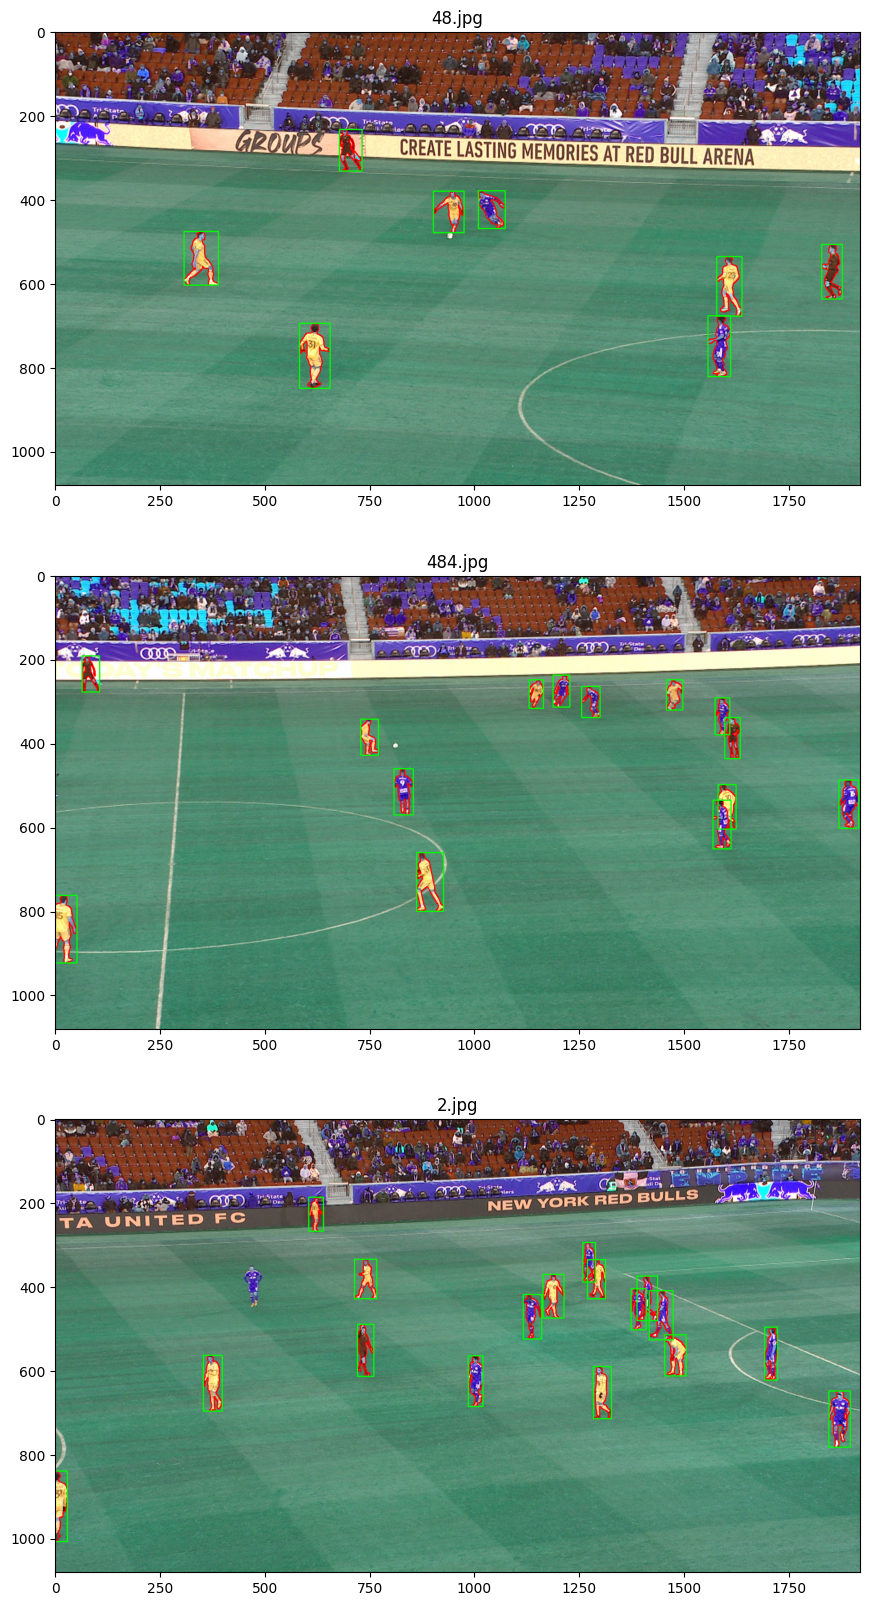

In [8]:
# Generate three random numbers between 0 and num_images
random_images = [data['images'][i] for i in np.random.randint(0, num_images, 3)]
# Create axes and subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 20))

for image_data, ax in zip(random_images, axs):
    # show image with matplotlib
    file_name = image_data['file_name']
    id = image_data['id']
    image = cv2.imread(image_folder + file_name)

    # Put segmentations on top of the image
    image_with_segments = draw_segments(image.copy(), data, id)

    # Draw bounding box
    image_with_segments_and_bbox = draw_bbox(image_with_segments.copy(), data, id)

    # Set title and show image
    ax.set_title(file_name)
    ax.imshow(image_with_segments_and_bbox)
    

### Check class distribution

Pretty sure category_id 1 is the only category in the dataset together with the supercategory (everything else). But just to be sure we check its count and check if there are no other categories.

In [9]:
# Determine the distribution of object classes in the dataset
class_distribution = {}
for annotation in data['annotations']:
    category_id = annotation['category_id']
    if category_id in class_distribution:
        class_distribution[category_id] += 1
    else:
        class_distribution[category_id] = 1

print(f"Class distribution: {class_distribution}")

Class distribution: {1: 7686}


### Check object (bounding box) size distribution
- Compute some statistics like mean, median, min and max
- Plot a histogram of the size distribution

This information can be helpful towards making decisions regarding input image size and anchor box sizes during model training.


Mean size: 5595.430228753578
Median size: 5176.84
Min size: 10.14
Max size: 23280.015


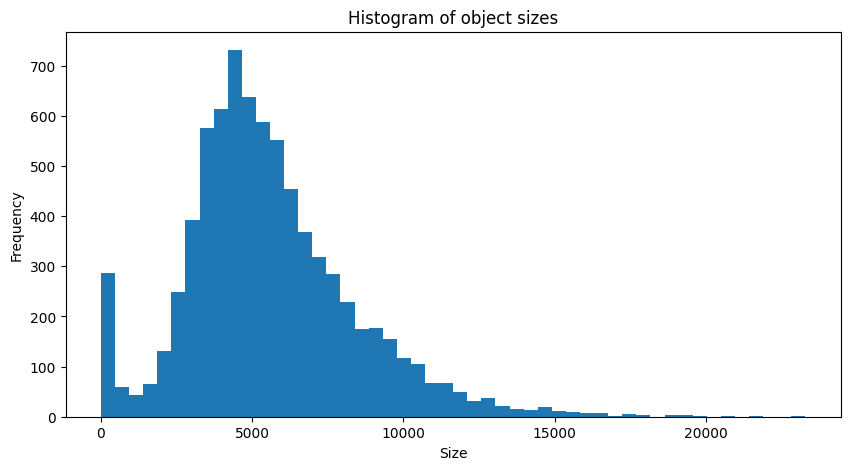

In [10]:
# Analyze the sizes of objects in your dataset. Compute statistics such as mean, median, minimum, and maximum sizes of objects
sizes = []
for annotation in data['annotations']:
    bbox = annotation['bbox']
    sizes.append(bbox[2] * bbox[3])

sizes = np.array(sizes)
mean_size = np.mean(sizes)
median_size = np.median(sizes)
min_size = np.min(sizes)
max_size = np.max(sizes)

print(f"Mean size: {mean_size}")
print(f"Median size: {median_size}")
print(f"Min size: {min_size}")
print(f"Max size: {max_size}")

# Plot histograms or box plots to visualize the distribution of object sizes
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=50)
plt.title('Histogram of object sizes')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()


### Object Aspect Ratios
- Take same steps as for the sizes
- Useful for appropriate anchor box selection

Mean aspect ratio: 0.471678032304169
Median aspect ratio: 0.4273040135871994
Min aspect ratio: 0.05823761665470208
Max aspect ratio: 3.4594594594594597


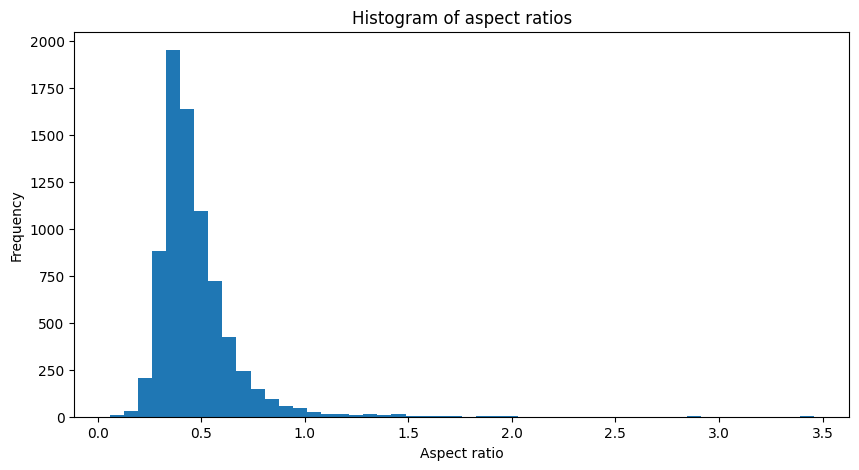

In [11]:
# Investigate the aspect ratios (width/height ratios) of objects in your dataset
aspect_ratios = []
for annotation in data['annotations']:
    bbox = annotation['bbox']
    aspect_ratios.append(bbox[2] / bbox[3])

aspect_ratios = np.array(aspect_ratios)
mean_aspect_ratio = np.mean(aspect_ratios)
median_aspect_ratio = np.median(aspect_ratios)
min_aspect_ratio = np.min(aspect_ratios)
max_aspect_ratio = np.max(aspect_ratios)

print(f"Mean aspect ratio: {mean_aspect_ratio}")
print(f"Median aspect ratio: {median_aspect_ratio}")
print(f"Min aspect ratio: {min_aspect_ratio}")
print(f"Max aspect ratio: {max_aspect_ratio}")

# Plot histograms or box plots to visualize the distribution of aspect ratios
plt.figure(figsize=(10, 5))
plt.hist(aspect_ratios, bins=50)
plt.title('Histogram of aspect ratios')
plt.xlabel('Aspect ratio')
plt.ylabel('Frequency')
plt.show()
